# CE-EM For Estimating SIRD Models
In this example notebook, we apply CE-EM to estimate the parameters of an SIRD compartmental model of the spread of COVID-19 in Germany.

The workbook is organized as follows:
- Imports
- Loading the data
- Defining a state-space model of the SIRD system
- Specifying the criteria for smoothing and learning
- Running CE-EM
- Plotting our results

In [1]:
# change director to the CEEM directory
import os
os.chdir('..')

## Imports
To define the model of the system, we import from `ceem.dynamics` the `C2DSystem` class to define a continuous-time system. We also import `DynJacMixin` to allow PyTorch to automatically compute Jacobians for the system. We import `AnalyticObsJacMixin` to allow us to analytically compute the observation Jacobian, which can improve efficiency.
We import criteria for smoothing and learning from `ceem.opt_criteria`, and the CEEM class from `ceem.ceem`.
We also set the default PyTorch data type to `torch.float64`.

In [2]:
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from ceem.dynamics import C2DSystem, AnalyticObsJacMixin, DynJacMixin
from ceem.opt_criteria import *
from ceem.ceem import CEEM

torch.set_default_dtype(torch.float64)
dtype=torch.get_default_dtype()

## Loading the data
Here, we load the COVID-19 data for Germany from 3/9/2020 to 6/11/2020. The data consists of the cumulative number of confirmed cases and deaths. We then prepare a torch tensor for the time-inputs to the system `t` and the observations `y`, which are the logarithms of the confirmed cases and deaths.

In [3]:
df = pd.read_csv('examples/germany.csv')
B = 1
T = len(df)
t = torch.arange(T, dtype=dtype).view(B,T).detach()
y = torch.tensor(df[['Confirmed', 'Deaths']].values, dtype=dtype).log().view(B,T,2).detach()

## Defining a state-space model of the SIRD system
To define a state-space model of a continuous-time system, we inherit the `C2DSystem` (which automatically applies a specified integration scheme to convert the continous-time dynamics to discrete-time). We need to implement two methods, `step_derivs` which returns the expect state-derivatives, and `observe` which returns the expected observation.
We're modeling the number of infections in a population, which is a strictly positive quantity that spans many orders of magnitude. As a result, we let the states of the system be the logarithm of the number of susceptible (S), infected (I), recovered (R), and deceased (D) individuals, as well as of the number of confirmed cases (C). We directly observe the logarithm of C and D, but none of the other quantities. 
We also define the `jac_obs_x`, which analytically computes returns the observation Jacobian with respect to `x`. 

In [4]:
class CompartmentalSystem(C2DSystem, nn.Module, AnalyticObsJacMixin, DynJacMixin):
    """
    System predicting log of confirmed cases and deaths.
    """
    
    def __init__(self, beta, gamma, mu):
        
        C2DSystem.__init__(self, dt=1.0, # integration time-step
                                 method='midpoint' # integration scheme
                          )
        nn.Module.__init__(self)

        self.logbeta = nn.Parameter(torch.tensor(beta).log())
        self.loggamma = nn.Parameter(torch.tensor(gamma).log())
        self.logmu = nn.Parameter(torch.tensor(mu).log())
        
        self._xdim = 5 # log [S, I, R, D, C]
        self._ydim = 2
        
    def step_derivs(self, t, x, u=None):
        
        beta, gamma, mu = (self.logbeta.exp(), self.loggamma.exp(), self.logmu.exp())
        x = x.exp()
        
        S = x[...,0:1]
        I = x[...,1:2]
        R = x[...,2:3]
        D = x[...,3:4]
        
        N = S+I+R+D
        
        dSdt = -beta*S*I/N
        dIdt = -dSdt - (gamma+mu)*I
        dRdt = gamma * I
        dDdt = mu * I
        dCdt = -dSdt
        
        dxdt_ = torch.cat([dSdt, dIdt, dRdt, dDdt, dCdt], dim=-1)
        dxdt = dxdt_ / x
        
        return dxdt
    
    def observe(self, t, x, u=None):
        
        return x[...,[4,3]]
    
    def jac_obs_x(self, t, x, u=None):

        B, T, n = x.shape

        return torch.eye(5)[[4,3],:].expand(B, T, 2, 5)
    
system = CompartmentalSystem(beta=0.1, gamma=0.04, mu=0.004)

## Specifying the Criteria for Smoothing and Learning
The next step is to specify the negative-log-likelihood for a given state-trajectory and choice of parameters. To do so, we must specify the process and observation noise covariances. We then pass in the inverse observation covariance along with `t` and `y` into `GaussainObservationCriterion` , which estimates the NLL of the observations given the states. We also pass the inverse dynamics covariance and `t` into `GaussianDynamicsCriterion`, which estimates the NLL of the states themselves. We then combine the NLL objectives using `GroupSOSCriterion`. Note that we only train  one trajectory, but if we were to have multiple trajectories, we would setup their criteria separately. We specify the solver keyword arguments for non-linear least squares in `smooth_solver_kwargs`.

The next step is to setup the criteria for learning. Since the `observe` function doesn't depend on the parameters, we only need to optimize the parametrers against the dynamics criterion. We can specify different criteria corresponding to different parameters, and even different optimizers for them. 

In [5]:
# specify criteria for smoothing and learning
wstd = 0.33
ystd = 1.0

Sig_v_inv = torch.ones(2) / (ystd ** 2)
Sig_w_inv = torch.ones(5) / (wstd ** 2)

smoothing_criteria = []
for b in range(B):
    # note: in this example B=1, but this is what we would do if it weren't
    obscrit = GaussianObservationCriterion(system, Sig_v_inv, t[b:b+1], y[b:b+1]) # pass in the inverse covariance
    dyncrit = GaussianDynamicsCriterion(system, Sig_w_inv, t[b:b+1]) 
    smoothing_criteria.append(GroupSOSCriterion([obscrit, dyncrit]))

# specify solver kwargs
smooth_solver_kwargs = {'verbose': 0, # to supress NLS printouts
                        'tr_rho': 0.1, # trust region for smoothing
                        'ftol':1e-5, # solve smoothing to coarse tolerance
                        'gtol':1e-5,
                        'xtol':1e-5
                       }

# specify learning criteria
# note: learning criteria do not need to be specified separately for each b in B
dyncrit = GaussianDynamicsCriterion(system, Sig_w_inv, t) 
learning_criteria = [dyncrit]# since the observation objective doesnt depend on parameters
learning_params = [list(system.parameters())] # the parameters we want optimized
learning_opts = ['scipy_minimize'] # the optimzer
learner_opt_kwargs = {'method': 'Nelder-Mead', # optimizer for learning
                      'tr_rho': 0.1 # trust region for learning
                     }

## Running CE-EM
To run CE-EM, we need to specify an initial guess. We choose sensible values to intialize S,I,R,D, and C. We then instantiate CE-EM with the smoothing criteria, learning criteria, parameters for learning, optimizers, and callbacks (not used in this example). 
We then train the system.

In [6]:
# specify initial guess
C0 = torch.tensor(df['Confirmed'],dtype=dtype).view(1,T,1)
S0 = torch.ones_like(C0) * C0.max() * 100 # inital guess of population
I0 = C0
D0 = torch.tensor(df['Deaths'], dtype=dtype).view(1,T,1)
R0 = 0.5 * (C0 + D0)
xsm = torch.cat([S0,I0,R0,D0,C0],dim=-1).log().detach()

# instantiate CEEM and train
ceem = CEEM(smoothing_criteria, learning_criteria, learning_params, learning_opts,
                [], lambda x: False)

ceem.train(xs=xsm, nepochs=100, smooth_solver_kwargs=smooth_solver_kwargs,
           learner_opt_kwargs=learner_opt_kwargs)

[0622 13:00:33 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

[0622 13:00:34 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 1.82555   |
| learn/end_gradnorm    | 2.30012   |
| learn/net_update_norm | 0.184262  |
| learn/start_feval     | 2.00524   |
| learn/start_gradnorm  | 2.2997    |
| learn/time            | 0.0515395 |
| smooth/fun            | 3.70903   |
| smooth/success        | True      |
| smooth/time           | 0.531427  |
-------------------------------------
[0622 13:00:34 @ceem.py:122] Executing smoothing step



/Users/kunalmenda/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

[0622 13:00:36 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 1.24391   |
| learn/end_gradnorm    | 2.32789   |
| learn/net_update_norm | 0.164081  |
| learn/start_feval     | 1.37373   |
| learn/start_gradnorm  | 2.32714   |
| learn/time            | 0.0507118 |
| smooth/fun            | 2.4615    |
| smooth/success        | True      |
| smooth/time           | 2.79536   |
-------------------------------------
[0622 13:00:37 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

[0622 13:00:37 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 1.1008    |
| learn/end_gradnorm    | 3.11335   |
| learn/net_update_norm | 0.122768  |
| learn/start_feval     | 1.18192   |
| learn/start_gradnorm  | 3.11399   |
| learn/time            | 0.0473775 |
| smooth/fun            | 2.2339    |
| smooth/success        | True      |
| smooth/time           | 0.698359  |
-------------------------------------
[0622 13:00:37 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

[0622 13:00:38 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 1.00792   |
| learn/end_gradnorm    | 4.02085   |
| learn/net_update_norm | 0.0906144 |
| learn/start_feval     | 1.05649   |
| learn/start_gradnorm  | 4.01989   |
| learn/time            | 0.0467019 |
| smooth/fun            | 2.09144   |
| smooth/success        | True      |
| smooth/time           | 0.908534  |
-------------------------------------
[0622 13:00:38 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

[0622 13:00:40 @ceem.py:125] Executing learning step
------------------------------------
| learn/end_feval       | 0.952799 |
| learn/end_gradnorm    | 4.87236  |
| learn/net_update_norm | 0.07031  |
| learn/start_feval     | 0.984232 |
| learn/start_gradnorm  | 4.87323  |
| learn/time            | 0.041114 |
| smooth/fun            | 2.0033   |
| smooth/success        | True     |
| smooth/time           | 1.48744  |
------------------------------------
[0622 13:00:40 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

[0622 13:00:40 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.916937  |
| learn/end_gradnorm    | 5.61954   |
| learn/net_update_norm | 0.0530927 |
| learn/start_feval     | 0.93644   |
| learn/start_gradnorm  | 5.61907   |
| learn/time            | 0.0431192 |
| smooth/fun            | 1.94696   |
| smooth/success        | True      |
| smooth/time           | 0.55139   |
-------------------------------------
[0622 13:00:40 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

[0622 13:00:41 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.892121  |
| learn/end_gradnorm    | 6.25716   |
| learn/net_update_norm | 0.0399734 |
| learn/start_feval     | 0.904185  |
| learn/start_gradnorm  | 6.25779   |
| learn/time            | 0.0422176 |
| smooth/fun            | 1.91191   |
| smooth/success        | True      |
| smooth/time           | 0.320265  |
-------------------------------------
[0622 13:00:41 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

[0622 13:00:41 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.874586  |
| learn/end_gradnorm    | 6.8026    |
| learn/net_update_norm | 0.0305285 |
| learn/start_feval     | 0.882346  |
| learn/start_gradnorm  | 6.80297   |
| learn/time            | 0.0434447 |
| smooth/fun            | 1.88993   |
| smooth/success        | True      |
| smooth/time           | 0.239945  |
-------------------------------------
[0622 13:00:41 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

[0622 13:00:41 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.861698  |
| learn/end_gradnorm    | 7.27556   |
| learn/net_update_norm | 0.0238601 |
| learn/start_feval     | 0.866995  |
| learn/start_gradnorm  | 7.27512   |
| learn/time            | 0.0400703 |
| smooth/fun            | 1.87558   |
| smooth/success        | True      |
| smooth/time           | 0.18319   |
-------------------------------------
[0622 13:00:41 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

[0622 13:00:41 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.851859  |
| learn/end_gradnorm    | 7.69165   |
| learn/net_update_norm | 0.0195078 |
| learn/start_feval     | 0.855758  |
| learn/start_gradnorm  | 7.69234   |
| learn/time            | 0.0384972 |
| smooth/fun            | 1.86562   |
| smooth/success        | True      |
| smooth/time           | 0.169423  |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

[0622 13:00:42 @ceem.py:125] Executing learning step


-------------------------------------
| learn/end_feval       | 0.843938  |
| learn/end_gradnorm    | 8.06491   |
| learn/net_update_norm | 0.0164597 |
| learn/start_feval     | 0.846989  |
| learn/start_gradnorm  | 8.06514   |
| learn/time            | 0.0377074 |
| smooth/fun            | 1.85816   |
| smooth/success        | True      |
| smooth/time           | 0.143889  |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

[0622 13:00:42 @ceem.py:125] Executing learning step


-------------------------------------
| learn/end_feval       | 0.83774   |
| learn/end_gradnorm    | 8.40616   |
| learn/net_update_norm | 0.0145184 |
| learn/start_feval     | 0.840283  |
| learn/start_gradnorm  | 8.40642   |
| learn/time            | 0.0404326 |
| smooth/fun            | 1.85221   |
| smooth/success        | True      |
| smooth/time           | 0.133973  |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]

[0622 13:00:42 @ceem.py:125] Executing learning step


-------------------------------------
| learn/end_feval       | 0.832112  |
| learn/end_gradnorm    | 8.72147   |
| learn/net_update_norm | 0.0130127 |
| learn/start_feval     | 0.834296  |
| learn/start_gradnorm  | 8.72088   |
| learn/time            | 0.0398408 |
| smooth/fun            | 1.84723   |
| smooth/success        | True      |
| smooth/time           | 0.110813  |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]

[0622 13:00:42 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.827141  |
| learn/end_gradnorm    | 9.01554   |
| learn/net_update_norm | 0.0120135 |
| learn/start_feval     | 0.829071  |
| learn/start_gradnorm  | 9.01496   |
| learn/time            | 0.0369861 |
| smooth/fun            | 1.84292   |
| smooth/success        | True      |
| smooth/time           | 0.0927347 |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 10.68it/s]

[0622 13:00:42 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.823037  |
| learn/end_gradnorm    | 9.29404   |
| learn/net_update_norm | 0.0113147 |
| learn/start_feval     | 0.824782  |
| learn/start_gradnorm  | 9.29332   |
| learn/time            | 0.0349273 |
| smooth/fun            | 1.83909   |
| smooth/success        | True      |
| smooth/time           | 0.0933078 |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00,  9.66it/s]

[0622 13:00:42 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.819412  |
| learn/end_gradnorm    | 9.55967   |
| learn/net_update_norm | 0.0107378 |
| learn/start_feval     | 0.821005  |
| learn/start_gradnorm  | 9.55854   |
| learn/time            | 0.0380061 |
| smooth/fun            | 1.83562   |
| smooth/success        | True      |
| smooth/time           | 0.1034    |
-------------------------------------
[0622 13:00:42 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 11.92it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.815767  |
| learn/end_gradnorm    | 9.81204   |
| learn/net_update_norm | 0.0102193 |
| learn/start_feval     | 0.817223  |
| learn/start_gradnorm  | 9.81114   |
| learn/time            | 0.0399601 |
| smooth/fun            | 1.83247   |
| smooth/success        | True      |
| smooth/time           | 0.0835499 |
-------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 12.11it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.812581   |
| learn/end_gradnorm    | 10.0525    |
| learn/net_update_norm | 0.00981794 |
| learn/start_feval     | 0.813921   |
| learn/start_gradnorm  | 10.0524    |
| learn/time            | 0.0395458  |
| smooth/fun            | 1.82958    |
| smooth/success        | True       |
| smooth/time           | 0.0822732  |
--------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.809733   |
| learn/end_gradnorm    | 10.2839    |
| learn/net_update_norm | 0.00938567 |
| learn/start_feval     | 0.810968   |
| learn/start_gradnorm  | 10.2831    |
| learn/time            | 0.036322   |
| smooth/fun            | 1.82692    |
| smooth/success        | True       |
| smooth/time           | 0.0851272  |
--------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.807119   |
| learn/end_gradnorm    | 10.5058    |
| learn/net_update_norm | 0.00903659 |
| learn/start_feval     | 0.808258   |
| learn/start_gradnorm  | 10.5055    |
| learn/time            | 0.0379129  |
| smooth/fun            | 1.82448    |
| smooth/success        | True       |
| smooth/time           | 0.0964797  |
--------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 11.76it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.804693   |
| learn/end_gradnorm    | 10.7175    |
| learn/net_update_norm | 0.00873475 |
| learn/start_feval     | 0.805744   |
| learn/start_gradnorm  | 10.7187    |
| learn/time            | 0.0351717  |
| smooth/fun            | 1.82222    |
| smooth/success        | True       |
| smooth/time           | 0.0847521  |
--------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 10.95it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.802412  |
| learn/end_gradnorm    | 10.9209   |
| learn/net_update_norm | 0.0083831 |
| learn/start_feval     | 0.80338   |
| learn/start_gradnorm  | 10.9221   |
| learn/time            | 0.0429635 |
| smooth/fun            | 1.82013   |
| smooth/success        | True      |
| smooth/time           | 0.0909795 |
-------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 12.96it/s]

[0622 13:00:43 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.799869   |
| learn/end_gradnorm    | 11.1154    |
| learn/net_update_norm | 0.00789157 |
| learn/start_feval     | 0.800741   |
| learn/start_gradnorm  | 11.1147    |
| learn/time            | 0.0461216  |
| smooth/fun            | 1.81821    |
| smooth/success        | True       |
| smooth/time           | 0.0767993  |
--------------------------------------
[0622 13:00:43 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 12.95it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.797883   |
| learn/end_gradnorm    | 11.3023    |
| learn/net_update_norm | 0.00755516 |
| learn/start_feval     | 0.798684   |
| learn/start_gradnorm  | 11.3015    |
| learn/time            | 0.0420027  |
| smooth/fun            | 1.81648    |
| smooth/success        | True       |
| smooth/time           | 0.0768843  |
--------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 14.08it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.796085   |
| learn/end_gradnorm    | 11.4809    |
| learn/net_update_norm | 0.00730872 |
| learn/start_feval     | 0.796823   |
| learn/start_gradnorm  | 11.4813    |
| learn/time            | 0.0470688  |
| smooth/fun            | 1.81488    |
| smooth/success        | True       |
| smooth/time           | 0.0706692  |
--------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 14.53it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.794418   |
| learn/end_gradnorm    | 11.6524    |
| learn/net_update_norm | 0.00702508 |
| learn/start_feval     | 0.795098   |
| learn/start_gradnorm  | 11.6529    |
| learn/time            | 0.0383077  |
| smooth/fun            | 1.8134     |
| smooth/success        | True       |
| smooth/time           | 0.0685432  |
--------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 15.50it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.792907   |
| learn/end_gradnorm    | 11.8183    |
| learn/net_update_norm | 0.00670828 |
| learn/start_feval     | 0.793533   |
| learn/start_gradnorm  | 11.818     |
| learn/time            | 0.0390157  |
| smooth/fun            | 1.81204    |
| smooth/success        | True       |
| smooth/time           | 0.0641964  |
--------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.791484  |
| learn/end_gradnorm    | 11.9769   |
| learn/net_update_norm | 0.0064845 |
| learn/start_feval     | 0.79206   |
| learn/start_gradnorm  | 11.9775   |
| learn/time            | 0.0368782 |
| smooth/fun            | 1.81079   |
| smooth/success        | True      |
| smooth/time           | 0.062088  |
-------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 15.22it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.79017    |
| learn/end_gradnorm    | 12.1299    |
| learn/net_update_norm | 0.00619257 |
| learn/start_feval     | 0.7907     |
| learn/start_gradnorm  | 12.1299    |
| learn/time            | 0.0412394  |
| smooth/fun            | 1.80963    |
| smooth/success        | True       |
| smooth/time           | 0.0652029  |
--------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 14.30it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.788949  |
| learn/end_gradnorm    | 12.2763   |
| learn/net_update_norm | 0.0059694 |
| learn/start_feval     | 0.789437  |
| learn/start_gradnorm  | 12.2771   |
| learn/time            | 0.0443073 |
| smooth/fun            | 1.80857   |
| smooth/success        | True      |
| smooth/time           | 0.0695811 |
-------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 14.99it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.787793  |
| learn/end_gradnorm    | 12.417    |
| learn/net_update_norm | 0.0057262 |
| learn/start_feval     | 0.788241  |
| learn/start_gradnorm  | 12.4176   |
| learn/time            | 0.0420923 |
| smooth/fun            | 1.80759   |
| smooth/success        | True      |
| smooth/time           | 0.0663352 |
-------------------------------------
[0622 13:00:44 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

[0622 13:00:44 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.78673    |
| learn/end_gradnorm    | 12.5534    |
| learn/net_update_norm | 0.00545805 |
| learn/start_feval     | 0.787142   |
| learn/start_gradnorm  | 12.5528    |
| learn/time            | 0.0408952  |
| smooth/fun            | 1.80668    |
| smooth/success        | True       |
| smooth/time           | 0.0643814  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 16.74it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.785783   |
| learn/end_gradnorm    | 12.6836    |
| learn/net_update_norm | 0.00525961 |
| learn/start_feval     | 0.786162   |
| learn/start_gradnorm  | 12.684     |
| learn/time            | 0.0391051  |
| smooth/fun            | 1.80586    |
| smooth/success        | True       |
| smooth/time           | 0.0594609  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.784857   |
| learn/end_gradnorm    | 12.81      |
| learn/net_update_norm | 0.00501646 |
| learn/start_feval     | 0.785206   |
| learn/start_gradnorm  | 12.8091    |
| learn/time            | 0.035893   |
| smooth/fun            | 1.80509    |
| smooth/success        | True       |
| smooth/time           | 0.0588205  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 17.10it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.784023   |
| learn/end_gradnorm    | 12.9295    |
| learn/net_update_norm | 0.00487209 |
| learn/start_feval     | 0.784344   |
| learn/start_gradnorm  | 12.9305    |
| learn/time            | 0.03726    |
| smooth/fun            | 1.80439    |
| smooth/success        | True       |
| smooth/time           | 0.0582201  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 17.23it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.783242   |
| learn/end_gradnorm    | 13.0462    |
| learn/net_update_norm | 0.00461608 |
| learn/start_feval     | 0.783538   |
| learn/start_gradnorm  | 13.0454    |
| learn/time            | 0.0376709  |
| smooth/fun            | 1.80374    |
| smooth/success        | True       |
| smooth/time           | 0.057424   |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.782509   |
| learn/end_gradnorm    | 13.157     |
| learn/net_update_norm | 0.00447242 |
| learn/start_feval     | 0.78278    |
| learn/start_gradnorm  | 13.1574    |
| learn/time            | 0.0373481  |
| smooth/fun            | 1.80315    |
| smooth/success        | True       |
| smooth/time           | 0.0594666  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.781841  |
| learn/end_gradnorm    | 13.2632   |
| learn/net_update_norm | 0.0043064 |
| learn/start_feval     | 0.782091  |
| learn/start_gradnorm  | 13.2639   |
| learn/time            | 0.034733  |
| smooth/fun            | 1.8026    |
| smooth/success        | True      |
| smooth/time           | 0.0574086 |
-------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.781193   |
| learn/end_gradnorm    | 13.3665    |
| learn/net_update_norm | 0.00407227 |
| learn/start_feval     | 0.781423   |
| learn/start_gradnorm  | 13.3657    |
| learn/time            | 0.0367778  |
| smooth/fun            | 1.8021     |
| smooth/success        | True       |
| smooth/time           | 0.0577862  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.04it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.78063    |
| learn/end_gradnorm    | 13.4657    |
| learn/net_update_norm | 0.00391341 |
| learn/start_feval     | 0.780842   |
| learn/start_gradnorm  | 13.4652    |
| learn/time            | 0.0394518  |
| smooth/fun            | 1.80164    |
| smooth/success        | True       |
| smooth/time           | 0.0551119  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

[0622 13:00:45 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.780075   |
| learn/end_gradnorm    | 13.56      |
| learn/net_update_norm | 0.00380541 |
| learn/start_feval     | 0.78027    |
| learn/start_gradnorm  | 13.5604    |
| learn/time            | 0.0370096  |
| smooth/fun            | 1.80121    |
| smooth/success        | True       |
| smooth/time           | 0.0563091  |
--------------------------------------
[0622 13:00:45 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 17.16it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.779579   |
| learn/end_gradnorm    | 13.6511    |
| learn/net_update_norm | 0.00361666 |
| learn/start_feval     | 0.779758   |
| learn/start_gradnorm  | 13.6509    |
| learn/time            | 0.0405024  |
| smooth/fun            | 1.80081    |
| smooth/success        | True       |
| smooth/time           | 0.0579241  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.23it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.77911    |
| learn/end_gradnorm    | 13.7383    |
| learn/net_update_norm | 0.00348587 |
| learn/start_feval     | 0.779275   |
| learn/start_gradnorm  | 13.7385    |
| learn/time            | 0.0367898  |
| smooth/fun            | 1.80045    |
| smooth/success        | True       |
| smooth/time           | 0.0545463  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.778638   |
| learn/end_gradnorm    | 13.8228    |
| learn/net_update_norm | 0.00331949 |
| learn/start_feval     | 0.77879    |
| learn/start_gradnorm  | 13.8222    |
| learn/time            | 0.03723    |
| smooth/fun            | 1.80012    |
| smooth/success        | True       |
| smooth/time           | 0.0546874  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.53it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.778243   |
| learn/end_gradnorm    | 13.9027    |
| learn/net_update_norm | 0.00323146 |
| learn/start_feval     | 0.778384   |
| learn/start_gradnorm  | 13.9033    |
| learn/time            | 0.0401757  |
| smooth/fun            | 1.79981    |
| smooth/success        | True       |
| smooth/time           | 0.0536417  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.51it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step
-------------------------------------
| learn/end_feval       | 0.777866  |
| learn/end_gradnorm    | 13.9792   |
| learn/net_update_norm | 0.0031156 |
| learn/start_feval     | 0.777995  |
| learn/start_gradnorm  | 13.9801   |
| learn/time            | 0.0364699 |
| smooth/fun            | 1.79952   |
| smooth/success        | True      |
| smooth/time           | 0.0536195 |
-------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.75it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.777499   |
| learn/end_gradnorm    | 14.0527    |
| learn/net_update_norm | 0.00299036 |
| learn/start_feval     | 0.777618   |
| learn/start_gradnorm  | 14.0535    |
| learn/time            | 0.0360394  |
| smooth/fun            | 1.79926    |
| smooth/success        | True       |
| smooth/time           | 0.0530259  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 18.62it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.777177   |
| learn/end_gradnorm    | 14.1232    |
| learn/net_update_norm | 0.00287034 |
| learn/start_feval     | 0.777286   |
| learn/start_gradnorm  | 14.124     |
| learn/time            | 0.0376272  |
| smooth/fun            | 1.79901    |
| smooth/success        | True       |
| smooth/time           | 0.0533789  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.776871   |
| learn/end_gradnorm    | 14.1911    |
| learn/net_update_norm | 0.00274876 |
| learn/start_feval     | 0.776972   |
| learn/start_gradnorm  | 14.1918    |
| learn/time            | 0.0381437  |
| smooth/fun            | 1.79879    |
| smooth/success        | True       |
| smooth/time           | 0.0528298  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 18.37it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.776581   |
| learn/end_gradnorm    | 14.256     |
| learn/net_update_norm | 0.00264833 |
| learn/start_feval     | 0.776673   |
| learn/start_gradnorm  | 14.2569    |
| learn/time            | 0.0387698  |
| smooth/fun            | 1.79858    |
| smooth/success        | True       |
| smooth/time           | 0.0541063  |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]

[0622 13:00:46 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.776305   |
| learn/end_gradnorm    | 14.3194    |
| learn/net_update_norm | 0.00250122 |
| learn/start_feval     | 0.77639    |
| learn/start_gradnorm  | 14.3192    |
| learn/time            | 0.0406857  |
| smooth/fun            | 1.79839    |
| smooth/success        | True       |
| smooth/time           | 0.051141   |
--------------------------------------
[0622 13:00:46 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 18.44it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.776066   |
| learn/end_gradnorm    | 14.3812    |
| learn/net_update_norm | 0.00237332 |
| learn/start_feval     | 0.776145   |
| learn/start_gradnorm  | 14.3801    |
| learn/time            | 0.035637   |
| smooth/fun            | 1.79822    |
| smooth/success        | True       |
| smooth/time           | 0.0539038  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 19.25it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.775862   |
| learn/end_gradnorm    | 14.439     |
| learn/net_update_norm | 0.00234552 |
| learn/start_feval     | 0.775935   |
| learn/start_gradnorm  | 14.4397    |
| learn/time            | 0.0383481  |
| smooth/fun            | 1.79806    |
| smooth/success        | True       |
| smooth/time           | 0.0516577  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


-------------------------------------
| learn/end_feval       | 0.775643  |
| learn/end_gradnorm    | 14.4959   |
| learn/net_update_norm | 0.0021956 |
| learn/start_feval     | 0.77571   |
| learn/start_gradnorm  | 14.4953   |
| learn/time            | 0.0371755 |
| smooth/fun            | 1.79791   |
| smooth/success        | True      |
| smooth/time           | 0.051181  |
-------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 19.47it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77542    |
| learn/end_gradnorm    | 14.5504    |
| learn/net_update_norm | 0.00212101 |
| learn/start_feval     | 0.775482   |
| learn/start_gradnorm  | 14.55      |
| learn/time            | 0.0423837  |
| smooth/fun            | 1.79777    |
| smooth/success        | True       |
| smooth/time           | 0.0510492  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.775229   |
| learn/end_gradnorm    | 14.6017    |
| learn/net_update_norm | 0.00207963 |
| learn/start_feval     | 0.775286   |
| learn/start_gradnorm  | 14.6023    |
| learn/time            | 0.0378     |
| smooth/fun            | 1.79764    |
| smooth/success        | True       |
| smooth/time           | 0.0512129  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step
--------------------------------------
| learn/end_feval       | 0.77506    |
| learn/end_gradnorm    | 14.6516    |
| learn/net_update_norm | 0.00196913 |
| learn/start_feval     | 0.775113   |
| learn/start_gradnorm  | 14.6516    |
| learn/time            | 0.0370251  |
| smooth/fun            | 1.79753    |
| smooth/success        | True       |
| smooth/time           | 0.0503014  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 19.87it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.774898   |
| learn/end_gradnorm    | 14.6986    |
| learn/net_update_norm | 0.00193809 |
| learn/start_feval     | 0.774947   |
| learn/start_gradnorm  | 14.6996    |
| learn/time            | 0.0355131  |
| smooth/fun            | 1.79742    |
| smooth/success        | True       |
| smooth/time           | 0.0499821  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 20.17it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.774742   |
| learn/end_gradnorm    | 14.7448    |
| learn/net_update_norm | 0.00181801 |
| learn/start_feval     | 0.774787   |
| learn/start_gradnorm  | 14.7447    |
| learn/time            | 0.0382941  |
| smooth/fun            | 1.79731    |
| smooth/success        | True       |
| smooth/time           | 0.0492668  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 19.82it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77459    |
| learn/end_gradnorm    | 14.7899    |
| learn/net_update_norm | 0.00172602 |
| learn/start_feval     | 0.774632   |
| learn/start_gradnorm  | 14.7891    |
| learn/time            | 0.0393884  |
| smooth/fun            | 1.79722    |
| smooth/success        | True       |
| smooth/time           | 0.0501495  |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 20.07it/s]

[0622 13:00:47 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.774469   |
| learn/end_gradnorm    | 14.8319    |
| learn/net_update_norm | 0.00171056 |
| learn/start_feval     | 0.774508   |
| learn/start_gradnorm  | 14.8325    |
| learn/time            | 0.0404738  |
| smooth/fun            | 1.79714    |
| smooth/success        | True       |
| smooth/time           | 0.049261   |
--------------------------------------
[0622 13:00:47 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77435    |
| learn/end_gradnorm    | 14.8732    |
| learn/net_update_norm | 0.00161669 |
| learn/start_feval     | 0.774386   |
| learn/start_gradnorm  | 14.873     |
| learn/time            | 0.0392592  |
| smooth/fun            | 1.79706    |
| smooth/success        | True       |
| smooth/time           | 0.0492055  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 20.54it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77424    |
| learn/end_gradnorm    | 14.914     |
| learn/net_update_norm | 0.00151312 |
| learn/start_feval     | 0.774273   |
| learn/start_gradnorm  | 14.9127    |
| learn/time            | 0.0381772  |
| smooth/fun            | 1.79698    |
| smooth/success        | True       |
| smooth/time           | 0.0483561  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 21.03it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.774143   |
| learn/end_gradnorm    | 14.9524    |
| learn/net_update_norm | 0.00148832 |
| learn/start_feval     | 0.774174   |
| learn/start_gradnorm  | 14.9521    |
| learn/time            | 0.0417872  |
| smooth/fun            | 1.79692    |
| smooth/success        | True       |
| smooth/time           | 0.0472466  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 21.33it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77402    |
| learn/end_gradnorm    | 14.9893    |
| learn/net_update_norm | 0.00143889 |
| learn/start_feval     | 0.774049   |
| learn/start_gradnorm  | 14.989     |
| learn/time            | 0.0381634  |
| smooth/fun            | 1.79685    |
| smooth/success        | True       |
| smooth/time           | 0.0465927  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 20.92it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.773929   |
| learn/end_gradnorm    | 15.0242    |
| learn/net_update_norm | 0.00139458 |
| learn/start_feval     | 0.773955   |
| learn/start_gradnorm  | 15.0245    |
| learn/time            | 0.0373314  |
| smooth/fun            | 1.7968     |
| smooth/success        | True       |
| smooth/time           | 0.0474869  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 21.50it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.773814   |
| learn/end_gradnorm    | 15.0589    |
| learn/net_update_norm | 0.00130335 |
| learn/start_feval     | 0.773838   |
| learn/start_gradnorm  | 15.0581    |
| learn/time            | 0.046565   |
| smooth/fun            | 1.79674    |
| smooth/success        | True       |
| smooth/time           | 0.0461784  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 21.46it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.773744   |
| learn/end_gradnorm    | 15.0918    |
| learn/net_update_norm | 0.00126741 |
| learn/start_feval     | 0.773766   |
| learn/start_gradnorm  | 15.0915    |
| learn/time            | 0.0358439  |
| smooth/fun            | 1.79669    |
| smooth/success        | True       |
| smooth/time           | 0.0462506  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 22.76it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


-------------------------------------
| learn/end_feval       | 0.773634  |
| learn/end_gradnorm    | 15.1232   |
| learn/net_update_norm | 0.0012295 |
| learn/start_feval     | 0.773655  |
| learn/start_gradnorm  | 15.1231   |
| learn/time            | 0.0386764 |
| smooth/fun            | 1.79665   |
| smooth/success        | True      |
| smooth/time           | 0.0436369 |
-------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 21.99it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.773556   |
| learn/end_gradnorm    | 15.1533    |
| learn/net_update_norm | 0.00118143 |
| learn/start_feval     | 0.773576   |
| learn/start_gradnorm  | 15.1532    |
| learn/time            | 0.036328   |
| smooth/fun            | 1.7966     |
| smooth/success        | True       |
| smooth/time           | 0.0451493  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 21.66it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77348    |
| learn/end_gradnorm    | 15.1823    |
| learn/net_update_norm | 0.00113911 |
| learn/start_feval     | 0.773498   |
| learn/start_gradnorm  | 15.1822    |
| learn/time            | 0.0368849  |
| smooth/fun            | 1.79657    |
| smooth/success        | True       |
| smooth/time           | 0.0458664  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 35.22it/s]

[0622 13:00:48 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.773462   |
| learn/end_gradnorm    | 15.2116    |
| learn/net_update_norm | 0.00108661 |
| learn/start_feval     | 0.773479   |
| learn/start_gradnorm  | 15.2107    |
| learn/time            | 0.0367143  |
| smooth/fun            | 1.79653    |
| smooth/success        | True       |
| smooth/time           | 0.0280835  |
--------------------------------------
[0622 13:00:48 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 31.90it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.77335    |
| learn/end_gradnorm    | 15.239     |
| learn/net_update_norm | 0.00108646 |
| learn/start_feval     | 0.773366   |
| learn/start_gradnorm  | 15.239     |
| learn/time            | 0.0381562  |
| smooth/fun            | 1.7965     |
| smooth/success        | True       |
| smooth/time           | 0.0310789  |
--------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 31.15it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


-------------------------------------
| learn/end_feval       | 0.773271  |
| learn/end_gradnorm    | 15.2655   |
| learn/net_update_norm | 0.0010485 |
| learn/start_feval     | 0.773286  |
| learn/start_gradnorm  | 15.2655   |
| learn/time            | 0.0393031 |
| smooth/fun            | 1.79646   |
| smooth/success        | True      |
| smooth/time           | 0.0317607 |
-------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 31.23it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.773197   |
| learn/end_gradnorm    | 15.2901    |
| learn/net_update_norm | 0.00103771 |
| learn/start_feval     | 0.77321    |
| learn/start_gradnorm  | 15.2909    |
| learn/time            | 0.0371497  |
| smooth/fun            | 1.79643    |
| smooth/success        | True       |
| smooth/time           | 0.0317292  |
--------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 30.84it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.773112    |
| learn/end_gradnorm    | 15.3154     |
| learn/net_update_norm | 0.000922262 |
| learn/start_feval     | 0.773125    |
| learn/start_gradnorm  | 15.3145     |
| learn/time            | 0.0397823   |
| smooth/fun            | 1.7964      |
| smooth/success        | True        |
| smooth/time           | 0.0320942   |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 31.26it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.773041    |
| learn/end_gradnorm    | 15.3383     |
| learn/net_update_norm | 0.000945729 |
| learn/start_feval     | 0.773053    |
| learn/start_gradnorm  | 15.3389     |
| learn/time            | 0.0444453   |
| smooth/fun            | 1.79638     |
| smooth/success        | True        |
| smooth/time           | 0.0316769   |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 24.76it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772951    |
| learn/end_gradnorm    | 15.3613     |
| learn/net_update_norm | 0.000846693 |
| learn/start_feval     | 0.772961    |
| learn/start_gradnorm  | 15.3605     |
| learn/time            | 0.0506843   |
| smooth/fun            | 1.79636     |
| smooth/success        | True        |
| smooth/time           | 0.0395292   |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 22.86it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772924    |
| learn/end_gradnorm    | 15.382      |
| learn/net_update_norm | 0.000890352 |
| learn/start_feval     | 0.772934    |
| learn/start_gradnorm  | 15.3829     |
| learn/time            | 0.0491897   |
| smooth/fun            | 1.79633     |
| smooth/success        | True        |
| smooth/time           | 0.043393    |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 23.03it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772894    |
| learn/end_gradnorm    | 15.4023     |
| learn/net_update_norm | 0.000842851 |
| learn/start_feval     | 0.772903    |
| learn/start_gradnorm  | 15.4029     |
| learn/time            | 0.0523866   |
| smooth/fun            | 1.79631     |
| smooth/success        | True        |
| smooth/time           | 0.0430065   |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 26.96it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step
---------------------------------------
| learn/end_feval       | 0.772852    |
| learn/end_gradnorm    | 15.4232     |
| learn/net_update_norm | 0.000753873 |
| learn/start_feval     | 0.772861    |
| learn/start_gradnorm  | 15.4223     |
| learn/time            | 0.0436851   |
| smooth/fun            | 1.79629     |
| smooth/success        | True        |
| smooth/time           | 0.0367901   |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step



100%|██████████| 1/1 [00:00<00:00, 30.57it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772813    |
| learn/end_gradnorm    | 15.4422     |
| learn/net_update_norm | 0.000767676 |
| learn/start_feval     | 0.772821    |
| learn/start_gradnorm  | 15.4425     |
| learn/time            | 0.0409309   |
| smooth/fun            | 1.79628     |
| smooth/success        | True        |
| smooth/time           | 0.0323567   |
---------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 29.89it/s]

[0622 13:00:49 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.772754   |
| learn/end_gradnorm    | 15.4612    |
| learn/net_update_norm | 0.00069933 |
| learn/start_feval     | 0.772761   |
| learn/start_gradnorm  | 15.4605    |
| learn/time            | 0.0546382  |
| smooth/fun            | 1.79626    |
| smooth/success        | True       |
| smooth/time           | 0.033057   |
--------------------------------------
[0622 13:00:49 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 22.14it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772763    |
| learn/end_gradnorm    | 15.4801     |
| learn/net_update_norm | 0.000673405 |
| learn/start_feval     | 0.77277     |
| learn/start_gradnorm  | 15.4792     |
| learn/time            | 0.0530185   |
| smooth/fun            | 1.79625     |
| smooth/success        | True        |
| smooth/time           | 0.0447822   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 24.93it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772736    |
| learn/end_gradnorm    | 15.4976     |
| learn/net_update_norm | 0.000675156 |
| learn/start_feval     | 0.772742    |
| learn/start_gradnorm  | 15.4974     |
| learn/time            | 0.0432637   |
| smooth/fun            | 1.79623     |
| smooth/success        | True        |
| smooth/time           | 0.0397649   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 32.69it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772717    |
| learn/end_gradnorm    | 15.5143     |
| learn/net_update_norm | 0.000656481 |
| learn/start_feval     | 0.772723    |
| learn/start_gradnorm  | 15.5143     |
| learn/time            | 0.0395316   |
| smooth/fun            | 1.79622     |
| smooth/success        | True        |
| smooth/time           | 0.0302831   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 32.96it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772637    |
| learn/end_gradnorm    | 15.5301     |
| learn/net_update_norm | 0.000615165 |
| learn/start_feval     | 0.772642    |
| learn/start_gradnorm  | 15.53       |
| learn/time            | 0.0474764   |
| smooth/fun            | 1.79621     |
| smooth/success        | True        |
| smooth/time           | 0.0300288   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 26.54it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772629    |
| learn/end_gradnorm    | 15.5445     |
| learn/net_update_norm | 0.000640293 |
| learn/start_feval     | 0.772635    |
| learn/start_gradnorm  | 15.5454     |
| learn/time            | 0.0586564   |
| smooth/fun            | 1.79619     |
| smooth/success        | True        |
| smooth/time           | 0.0371699   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 25.81it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772618    |
| learn/end_gradnorm    | 15.5595     |
| learn/net_update_norm | 0.000571414 |
| learn/start_feval     | 0.772622    |
| learn/start_gradnorm  | 15.5592     |
| learn/time            | 0.0563011   |
| smooth/fun            | 1.79618     |
| smooth/success        | True        |
| smooth/time           | 0.0383504   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 25.09it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772588    |
| learn/end_gradnorm    | 15.5729     |
| learn/net_update_norm | 0.000597408 |
| learn/start_feval     | 0.772592    |
| learn/start_gradnorm  | 15.5737     |
| learn/time            | 0.0462327   |
| smooth/fun            | 1.79617     |
| smooth/success        | True        |
| smooth/time           | 0.0394523   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 29.35it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.77256     |
| learn/end_gradnorm    | 15.587      |
| learn/net_update_norm | 0.000515987 |
| learn/start_feval     | 0.772564    |
| learn/start_gradnorm  | 15.5865     |
| learn/time            | 0.0420027   |
| smooth/fun            | 1.79616     |
| smooth/success        | True        |
| smooth/time           | 0.0336844   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 32.60it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772556    |
| learn/end_gradnorm    | 15.5993     |
| learn/net_update_norm | 0.000562625 |
| learn/start_feval     | 0.77256     |
| learn/start_gradnorm  | 15.6002     |
| learn/time            | 0.0419675   |
| smooth/fun            | 1.79615     |
| smooth/success        | True        |
| smooth/time           | 0.0303524   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 33.12it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772543    |
| learn/end_gradnorm    | 15.6129     |
| learn/net_update_norm | 0.000472954 |
| learn/start_feval     | 0.772547    |
| learn/start_gradnorm  | 15.612      |
| learn/time            | 0.0430447   |
| smooth/fun            | 1.79615     |
| smooth/success        | True        |
| smooth/time           | 0.0299051   |
---------------------------------------
[0622 13:00:50 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 28.26it/s]

[0622 13:00:50 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772528    |
| learn/end_gradnorm    | 15.6257     |
| learn/net_update_norm | 0.000472781 |
| learn/start_feval     | 0.772532    |
| learn/start_gradnorm  | 15.6252     |
| learn/time            | 0.0449768   |
| smooth/fun            | 1.79614     |
| smooth/success        | True        |
| smooth/time           | 0.0347511   |
---------------------------------------
[0622 13:00:51 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 28.39it/s]

[0622 13:00:51 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772531    |
| learn/end_gradnorm    | 15.6381     |
| learn/net_update_norm | 0.000463932 |
| learn/start_feval     | 0.772534    |
| learn/start_gradnorm  | 15.6377     |
| learn/time            | 0.0462611   |
| smooth/fun            | 1.79613     |
| smooth/success        | True        |
| smooth/time           | 0.0348474   |
---------------------------------------
[0622 13:00:51 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 30.52it/s]

[0622 13:00:51 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772512    |
| learn/end_gradnorm    | 15.6491     |
| learn/net_update_norm | 0.000475078 |
| learn/start_feval     | 0.772515    |
| learn/start_gradnorm  | 15.6496     |
| learn/time            | 0.0466369   |
| smooth/fun            | 1.79613     |
| smooth/success        | True        |
| smooth/time           | 0.0323884   |
---------------------------------------
[0622 13:00:51 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 32.44it/s]

[0622 13:00:51 @ceem.py:125] Executing learning step


--------------------------------------
| learn/end_feval       | 0.772504   |
| learn/end_gradnorm    | 15.6597    |
| learn/net_update_norm | 0.00045931 |
| learn/start_feval     | 0.772506   |
| learn/start_gradnorm  | 15.6602    |
| learn/time            | 0.0410589  |
| smooth/fun            | 1.79612    |
| smooth/success        | True       |
| smooth/time           | 0.030564   |
--------------------------------------
[0622 13:00:51 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 33.57it/s]

[0622 13:00:51 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.77247     |
| learn/end_gradnorm    | 15.6706     |
| learn/net_update_norm | 0.000410644 |
| learn/start_feval     | 0.772472    |
| learn/start_gradnorm  | 15.6703     |
| learn/time            | 0.039487    |
| smooth/fun            | 1.79611     |
| smooth/success        | True        |
| smooth/time           | 0.0294891   |
---------------------------------------
[0622 13:00:51 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 35.00it/s]

[0622 13:00:51 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772498    |
| learn/end_gradnorm    | 15.6821     |
| learn/net_update_norm | 0.000385003 |
| learn/start_feval     | 0.772501    |
| learn/start_gradnorm  | 15.6811     |
| learn/time            | 0.0408897   |
| smooth/fun            | 1.79611     |
| smooth/success        | True        |
| smooth/time           | 0.0282643   |
---------------------------------------
[0622 13:00:51 @ceem.py:122] Executing smoothing step


100%|██████████| 1/1 [00:00<00:00, 35.32it/s]

[0622 13:00:51 @ceem.py:125] Executing learning step


---------------------------------------
| learn/end_feval       | 0.772468    |
| learn/end_gradnorm    | 15.6908     |
| learn/net_update_norm | 0.000440828 |
| learn/start_feval     | 0.77247     |
| learn/start_gradnorm  | 15.692      |
| learn/time            | 0.0380579   |
| smooth/fun            | 1.7961      |
| smooth/success        | True        |
| smooth/time           | 0.0279946   |
---------------------------------------


## Plotting our results
Let's see what parameters were learning, and what the curves for S,I,R,D, and C look like after training. We'll also see how well the smoothed estimates for C and D match the data.

In [7]:
# print parameters
print('beta*: %.3e' % system.logbeta.exp())
print('gamma*: %.3e' % system.loggamma.exp())
print('mu*: %.3e' % system.logmu.exp())

beta*: 1.676e-01
gamma*: 5.608e-02
mu*: 2.341e-03


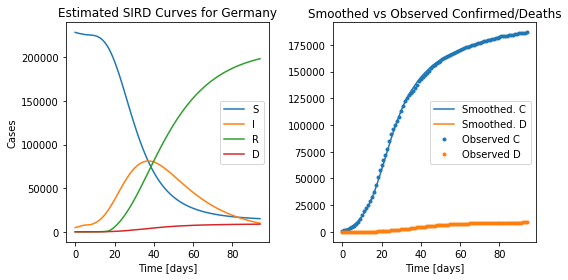

In [8]:
# plot smoothed SIR curves
xsmnp = xsm.exp().detach().numpy()
tnp = t[0,:].detach().numpy()
S = xsmnp[0,:,0]
I = xsmnp[0,:,1]
R = xsmnp[0,:,2]
D = xsmnp[0,:,3]
C = xsmnp[0,:,4]
Cy = df['Confirmed'].values
Dy = df['Deaths'].values

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tnp,S, label='S')
plt.plot(tnp,I, label='I')
plt.plot(tnp,R, label='R')
plt.plot(tnp,D, label='D')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('Estimated SIRD Curves for Germany')
plt.legend()

plt.subplot(1,2,2)
plt.plot(tnp,C, label='Smoothed. C', color='C0')
plt.plot(tnp,D, label='Smoothed. D', color='C1')
plt.plot(tnp,Cy, '.', label='Observed C', color='C0')
plt.plot(tnp,Dy, '.' ,label='Observed D', color='C1')
plt.xlabel('Time [days]')
plt.title('Smoothed vs Observed Confirmed/Deaths')
plt.legend()
plt.tight_layout()